In [1]:
%pylab inline

import numpy as np
import tensorflow as tf


from keras.models import Input, Sequential, Model
from keras.layers import Dense, BatchNormalization, Layer, Activation, Reshape, Dropout, LeakyReLU
from keras.datasets.mnist import load_data
from keras.utils import np_utils
from keras.losses import categorical_crossentropy
from keras import backend as K

from sklearn.metrics import accuracy_score

from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.4, allow_growth=True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(sess)

## Data

In [3]:
(train_x, train_y), (test_x, test_y) = load_data()

train_noise = np.random.normal(0, 1, size=(train_x.shape[0], 100))
test_noise = np.random.normal(0, 1, size=(test_x.shape[0], 100))

train_x = train_x.reshape((-1, 784))
test_x = test_x.reshape((-1, 784))
train_x = train_x/255.
test_x = test_x/255.

train_y = np_utils.to_categorical(train_y)
test_y = np_utils.to_categorical(test_y)

print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('train_noise:', train_noise.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)
print('test_noise:', test_noise.shape)

train_x: (60000, 784)
train_y: (60000, 10)
train_noise: (60000, 100)
test_x: (10000, 784)
test_y: (10000, 10)
test_noise: (10000, 100)


## Tools

In [4]:
def make_trainable(model, trainable: bool):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable

def display_image(image):
    display(imshow(image.reshape((28, 28))*255, cmap='gray'))
    
def _to_tensor(x, dtype):
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x

## Model

### Generator Model

In [36]:
# Generator Model 
def create_generator_model(loss='categorical_crossentropy'):
    generator = Sequential(name='Generator')
    generator.add(Dense(196, batch_input_shape=(None, 100), name='g_layer_01'))
#     generator.add(BatchNormalization())
    generator.add(Activation('sigmoid'))

    generator.add(Dense(289))
#     generator.add(BatchNormalization())
    generator.add(Activation('sigmoid'))

    generator.add(Dense(441))
#     generator.add(BatchNormalization())
    generator.add(Activation('sigmoid'))
    
    generator.add(Dense(784))
#     generator.add(BatchNormalization())
    generator.add(Activation('sigmoid'))

    generator.compile(loss=loss, optimizer='adam')
    return generator

generator = create_generator_model()
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_layer_01 (Dense)           (None, 196)               19796     
_________________________________________________________________
activation_6 (Activation)    (None, 196)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 289)               56933     
_________________________________________________________________
activation_7 (Activation)    (None, 289)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 441)               127890    
_________________________________________________________________
activation_8 (Activation)    (None, 441)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 784)               346528    
__________

### Discriminator Model

In [37]:
def custom_binary_crossentropy(y_true, y_pred):
    print('discriminator loss')
    epsilon = _to_tensor( 10e-8, y_pred.dtype.base_dtype)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    return - y_true * K.log(y_pred) - (1 - y_true) * K.log(1-y_pred)

def create_discriminator_model(loss='binary_crossentropy'):
    discriminator = Sequential(name='Discriminator')
    discriminator.add(Dense(784, batch_input_shape=(None, 784), name='d_layer_01'))
#     discriminator.add(Dropout(0.2))
    discriminator.add(LeakyReLU())

    discriminator.add(Dense(441))
#     discriminator.add(Dropout(0.2))
    discriminator.add(LeakyReLU())

    discriminator.add(Dense(289))
#     discriminator.add(Dropout(0.2))
    discriminator.add(LeakyReLU())

    discriminator.add(Dense(2))
#     discriminator.add(Dropout(0.2))
    discriminator.add(Activation('sigmoid'))
    discriminator.compile(loss=loss, optimizer='adam')
    return discriminator

discriminator = create_discriminator_model(loss=custom_binary_crossentropy)
discriminator.summary()

discriminator loss
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_layer_01 (Dense)           (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 441)               346185    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 441)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 289)               127738    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 289)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 58

### GAN Model

gan model 변수는 generator를 trainining 하기 위한 모델입니다. <br>
generator를 거쳐 generated images가 만들어지면, discriminator가 


In [124]:
def minigame_loss(y_true, y_pred):
    return - categorical_crossentropy(y_true, y_pred)

def heuristic_loss(y_true, y_pred):
    # 실제로는 cross entropy
    epsilon = _to_tensor( 10e-8, y_pred.dtype.base_dtype)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    return - y_true * K.log(y_pred)

def maximum_likelihood(y_true, y_pred):
    return y_true * K.exp()


def create_gan_model(generator, discriminator, loss='categorical_crossentropy'):
    gan = Sequential()
    gan.add(generator)
    discriminator.trainable = False
    gan.add(discriminator)
    gan.compile(loss=loss, optimizer='adam')
    return gan

gan = create_gan_model(generator, discriminator)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Sequential)       (None, 784)               551147    
_________________________________________________________________
Discriminator (Sequential)   (None, 2)                 1089943   
Total params: 1,641,090.0
Trainable params: 1,641,090.0
Non-trainable params: 0.0
_________________________________________________________________


In [138]:
noise_x, noise_y = next_noise_batch(test_noise, 1)
gan.train_on_batch(noise_x[0:1], noise_y[0:1])


1.192093e-07

## Train

In [10]:
def next_batch(x, y, noise, idx, batch_size=250):
    return x[idx: idx+batch_size], y[idx: idx+batch_size], noise[idx: idx+batch_size]

def next_noise_batch(noise, idx, batch_size=250):    
    y = np.zeros((batch_size, 2))
    y[:, 1] = 1    
    return noise[idx: idx+batch_size], y

def shuffle(x, y, n):
    N = x.shape[0]
    permu = np.random.permutation(N)
    x = x[permu]
    y = y[permu]
    n = n[permu]
    return x, y, n

def concatenate_images(true_images, generated_images):
    n_true = true_images.shape[0]
    combined_x = np.concatenate((true_images, generated_images))
    combined_y = np.zeros((combined_x.shape[0], 2))
    combined_y[:n_true, 0] = 1 # True Images [1, 0]
    combined_y[n_true:, 1] = 1 # Generated Images [0, 1]
    
    return combined_x, combined_y


[0] d loss: 0.00828428 , g loss: 0.000930867
[1] d loss: 1.36684e-07 , g loss: 1.19209e-07
[2] d loss: 1.36213e-07 , g loss: 1.19209e-07


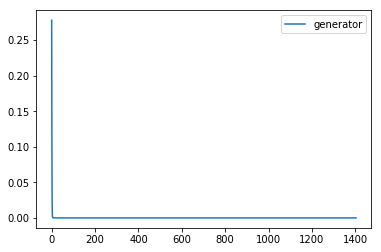

In [126]:
BATCH_SIZE = 128
EPOCH=300

def train(data_x, data_y, data_n, epochs=10, batch_size=128):
    N = train_x.shape[0]
    
    global_d_losses = []
    global_g_losses = []
    
    for epoch in range(epochs):
        data_x, data_y, data_n = shuffle(data_x, data_y, data_n)
        d_losses = []
        g_losses = []
        for step in range(0, N-BATCH_SIZE, BATCH_SIZE):
            # sample_noise: Sample minibatch of m(BATCH_SIZE) noise samples {z^1, ..., z^m} from noise prior p_g(z)
            # sample_x: Sample minibatch of m examples {x^1, ..., x^m} from data generating distribution
            sample_x, sample_y, sample_noise = next_batch(data_x, data_y, data_n, step, batch_size=batch_size)

            # combine true images and generated images for training discriminator
            generated_images = generator.predict(sample_noise)
            combined_x, combined_y = concatenate_images(sample_x, generated_images)

            # Update the discriminator by ascending tis stochastic gradient
            # train_on_batch is like fit function with only just a single minibatch. so it's trained
            d_loss = discriminator.train_on_batch(combined_x, combined_y)

            # Sample minibatch of m noise samples {z^1, ..., z^m} from noise prior p_g(z)
            noise_x, noise_y = next_noise_batch(data_n, step, batch_size=batch_size)

            # Update the generator by descending its stochastic gradient
            g_loss = gan.train_on_batch(noise_x, noise_y)

            d_losses.append(d_loss)
            g_losses.append(g_loss)
            global_d_losses.append(d_loss)
            global_g_losses.append(g_loss)

        _dl = np.array(d_losses)
        _gl = np.array(g_losses)
        print(f'[{epoch}]', 'd loss:', _dl.mean(), ', g loss:', _gl.mean())
#     plot(global_d_losses, label='dicriminator')
    plot(global_g_losses, label='generator')
    legend()
    
    return global_d_losses, global_g_losses
            
d_losses, g_losses = train(train_x, train_y, train_noise, epochs=EPOCH, batch_size=BATCH_SIZE)


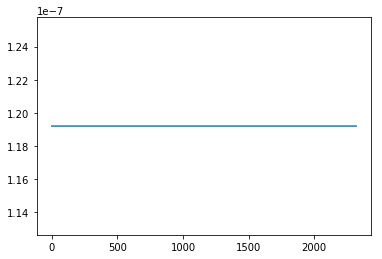

In [11]:
plot(g_losses[20:])

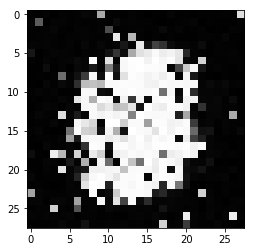

In [22]:
noise_x, noise_y = next_noise_batch(test_noise, 1)

d = generator.predict(noise_x)
display_image(d[np.random.randint(250)])

## Discriminator Accuracy

In [40]:
N = test_x.shape[0]
generated_images = generator.predict(test_noise)
_combined_x = np.concatenate((test_x, generated_images))
y_true = np.zeros((_combined_x.shape[0], 2))
y_true[:N, 0] = 1
y_true[N:, 1] = 1

y_pred = discriminator.predict(_combined_x)

y_true = np.argmax(y_true, axis=1)
y_pred = np.argmax(y_pred, axis=1)

discriminator_accuracy = accuracy_score(y_true, y_pred)
print(f"Discriminator's Accuracy Score: {discriminator_accuracy}" )

Discriminator's Accuracy Score: 0.46715


In [39]:
print('REAL IMAGES')
print(np.argmax(discriminator.predict(test_x[0:20]), axis=1))
print()

noise_x, noise_y = next_noise_batch(test_noise, np.random.randint(1000))
d = generator.predict(noise_x[:20])

print('Generated Images')
print(np.argmax(discriminator.predict(d[0:20]), axis=1))

REAL IMAGES
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Generated Images
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
